<a href="https://colab.research.google.com/github/O-NS23/Week-3/blob/main/ResNet50_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import kagglehub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.utils import class_weight
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import joblib

In [45]:
# --- Configuration (can be kept separate or moved to a main config block) ---
IMG_SIZE = (224, 224) # Standard size for ResNet50 input
BATCH_SIZE = 32
SEED = 42

**--- 1. Explore and Understand the Data ---**

In [46]:
# --- 1. Explore and Understand the Data ---
print("--- 1. Explore and Understand the Data ---")

--- 1. Explore and Understand the Data ---


In [47]:
# 1.1 Download and Load the Image Dataset using KaggleHub
print("\n--- Downloading dataset using KaggleHub ---")
downloaded_path = kagglehub.dataset_download("farzadnekouei/trash-type-image-dataset")
print(f"Initial downloaded path: {downloaded_path}")

# Adjust DATA_DIR to point to the actual content
# Based on previous runs, the actual class folders are inside another folder
# named 'TrashType_Image_Dataset' within the downloaded_path.
DATA_DIR = os.path.join(downloaded_path, 'TrashType_Image_Dataset')
print(f"Adjusted DATA_DIR to: {DATA_DIR}")

# Verify if the adjusted DATA_DIR exists and contains subdirectories
if not os.path.exists(DATA_DIR):
    print(f"Error: Adjusted DATA_DIR '{DATA_DIR}' does not exist.")
    print("Please ensure the dataset is unzipped correctly and the path is accurate.")
    # Attempt to list contents of downloaded_path to debug
    print(f"Contents of {downloaded_path}: {os.listdir(downloaded_path)}")
    exit()

# Load dataset using image_dataset_from_directory
# This is a good tool for initial exploration as it handles direct directory structure.
# However, for train/test split, we'll later switch to flow_from_dataframe as per previous design.
# Here, we use it to quickly get class names and counts.

# We'll use a temporary dataset to infer classes and counts, not for direct model input.
# Set shuffle=False to get consistent order for inspection
temp_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='categorical', # or 'int' for integer labels if preferred for initial count
    image_size=IMG_SIZE,
    interpolation='nearest', # or 'bilinear'
    batch_size=BATCH_SIZE,
    shuffle=False # Do not shuffle for counting and visualization
)

class_names = temp_dataset.class_names
print(f"\nDiscovered Class Labels: {class_names}")
print(f"Number of Classes: {len(class_names)}")



--- Downloading dataset using KaggleHub ---
Initial downloaded path: /kaggle/input/trash-type-image-dataset
Adjusted DATA_DIR to: /kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset
Found 2527 files belonging to 6 classes.

Discovered Class Labels: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Number of Classes: 6



--- Checking Image Count per Class ---
Image counts per class:
  cardboard: 403
  glass: 501
  metal: 410
  paper: 594
  plastic: 482
  trash: 137


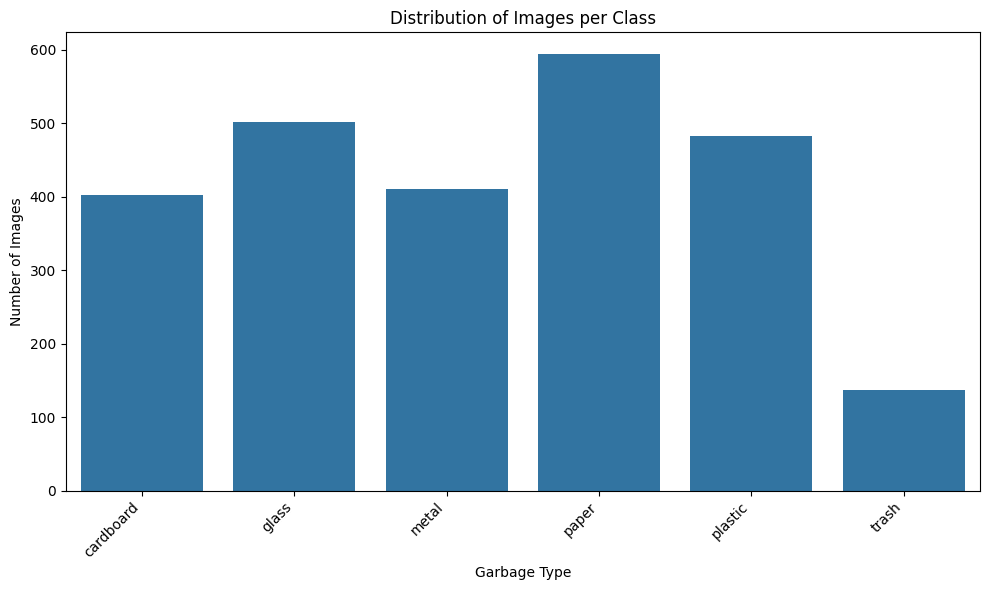


⚠️ Class imbalance detected! The ratio of max to min class count is 4.34.
This confirms the challenge stated in the project description.


In [48]:
# 1.2 Check the number of images per class to ensure balance
print("\n--- Checking Image Count per Class ---")
image_counts = Counter()
all_labels = []

# Iterate through the dataset to collect actual labels
for images, labels_one_hot in temp_dataset:
    # Convert one-hot encoded labels back to integer labels
    labels = tf.argmax(labels_one_hot, axis=1).numpy()
    all_labels.extend(labels)

# Map integer labels back to class names for display
label_names = [class_names[label_idx] for label_idx in all_labels]
image_counts.update(label_names)

print("Image counts per class:")
for class_name in class_names:
    print(f"  {class_name}: {image_counts[class_name]}")

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()))
plt.title('Distribution of Images per Class')
plt.xlabel('Garbage Type')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Detect and report imbalance
min_count = min(image_counts.values())
max_count = max(image_counts.values())
if max_count / min_count > 1.5: # Threshold for considering imbalance, adjust as needed
    print("\n⚠️ Class imbalance detected! The ratio of max to min class count is "
          f"{max_count / min_count:.2f}.")
    print("This confirms the challenge stated in the project description.")
else:
    print("\nClass distribution appears relatively balanced.")



--- Visualizing Sample Images ---


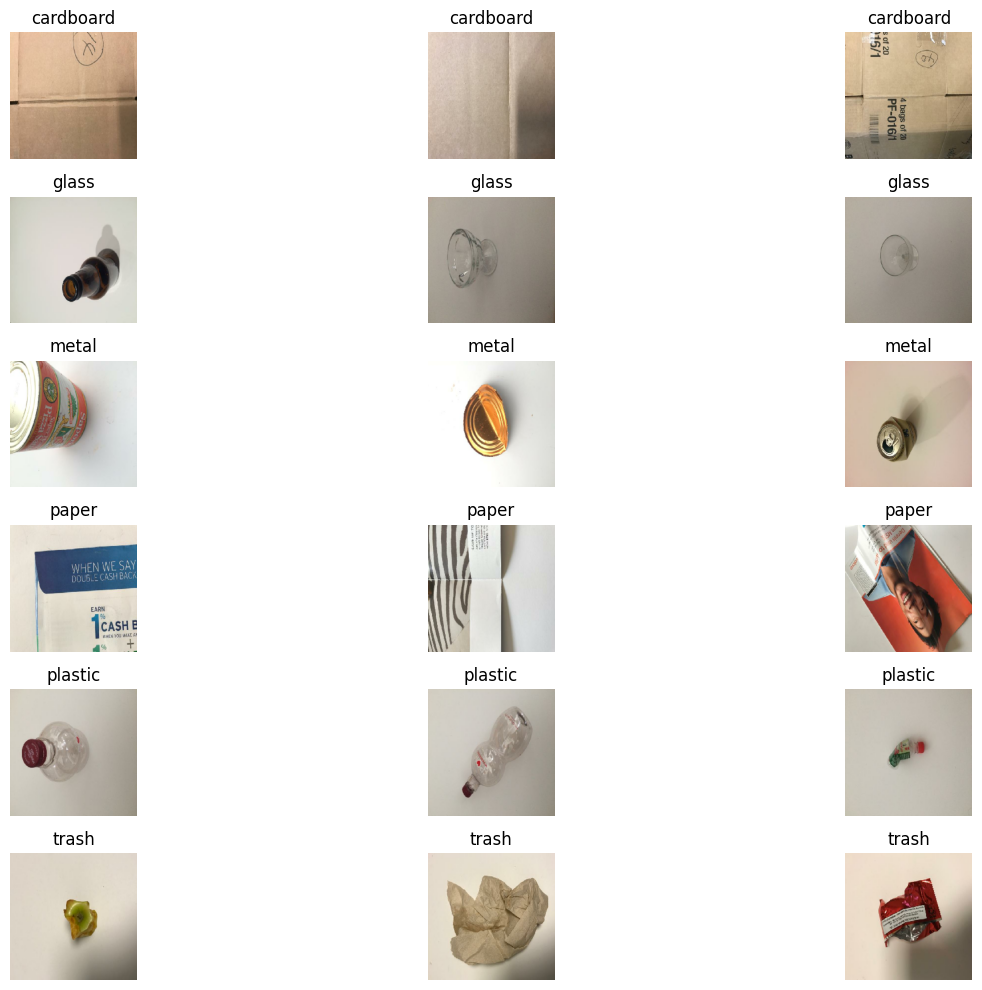

In [49]:
# 1.3 Visualize sample images from each class
print("\n--- Visualizing Sample Images ---")
plt.figure(figsize=(15, 10))
num_samples_per_class = 3 # Number of samples to visualize per class

# Iterate through the dataset to pick samples
samples_per_class = {name: 0 for name in class_names}
displayed_images = 0

for images, labels_one_hot in temp_dataset:
    # Convert one-hot encoded labels to integer indices
    labels_indices = tf.argmax(labels_one_hot, axis=1).numpy()

    for i in range(images.shape[0]): # Iterate through images in the current batch
        label_idx = labels_indices[i]
        class_name = class_names[label_idx]

        if samples_per_class[class_name] < num_samples_per_class:
            ax = plt.subplot(len(class_names), num_samples_per_class, displayed_images + 1)
            plt.imshow(images[i].numpy().astype("uint8")) # image_dataset_from_directory output is 0-255
            plt.title(f"{class_name}")
            plt.axis("off")
            samples_per_class[class_name] += 1
            displayed_images += 1

        # Stop if we've collected enough samples for all classes
        if all(samples_per_class[name] == num_samples_per_class for name in class_names):
            break
    if all(samples_per_class[name] == num_samples_per_class for name in class_names):
        break # Exit outer loop as well

plt.tight_layout()
plt.show()


In [50]:
# 1.4 Understand image dimensions, color channels, and class labels.
print("\n--- Image and Label Characteristics ---")

# Get one batch from the dataset to inspect properties
for images, labels_one_hot in temp_dataset.take(1):
    sample_image = images[0]
    sample_label_one_hot = labels_one_hot[0]

    print(f"Sample Image Dimensions: {sample_image.shape}") # (height, width, channels)
    print(f"Sample Image Data Type: {sample_image.dtype}") # Should be uint8 from image_dataset_from_directory

    # Color Channels
    if sample_image.shape[-1] == 3:
        print("Color Channels: 3 (RGB)")
    elif sample_image.shape[-1] == 1:
        print("Color Channels: 1 (Grayscale)")
    else:
        print(f"Color Channels: {sample_image.shape[-1]} (Unusual)")

    print(f"Number of Classes (from one-hot label length): {len(sample_label_one_hot)}")
    print(f"Example One-Hot Label: {sample_label_one_hot.numpy()}")
    print(f"Corresponding Class Name: {class_names[tf.argmax(sample_label_one_hot).numpy()]}")
    break # Only need one batch for this info

print("\nData exploration complete. Proceeding to model building and training...")


--- Image and Label Characteristics ---
Sample Image Dimensions: (224, 224, 3)
Sample Image Data Type: <dtype: 'uint8'>
Color Channels: 3 (RGB)
Number of Classes (from one-hot label length): 6
Example One-Hot Label: [1. 0. 0. 0. 0. 0.]
Corresponding Class Name: cardboard

Data exploration complete. Proceeding to model building and training...



--- Checking Image Count and Distributions per Split ---
Overall Class Distribution (Counts): Counter({'paper': 594, 'glass': 501, 'plastic': 482, 'metal': 410, 'cardboard': 403, 'trash': 137})


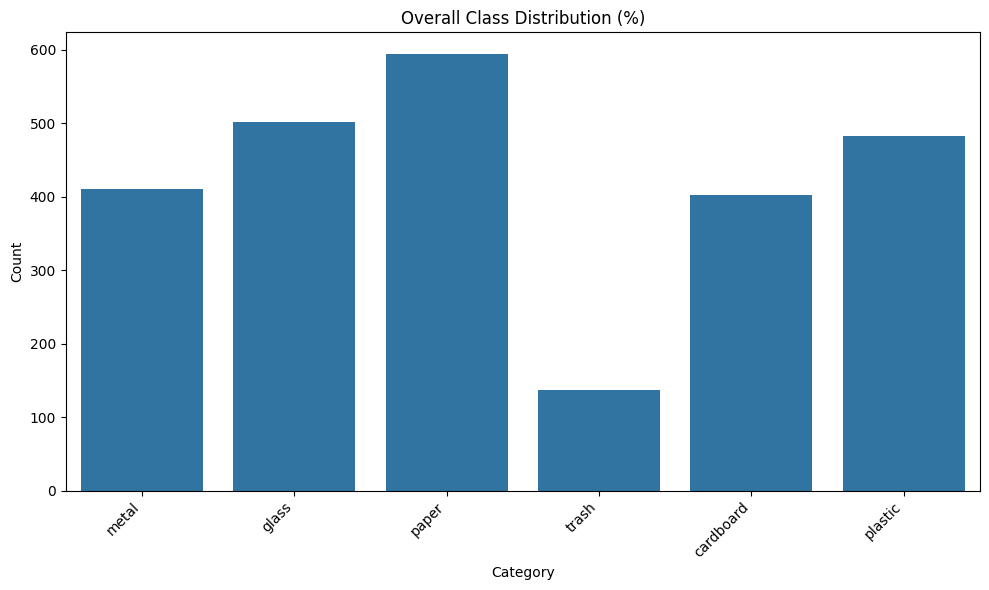

Training Set Class Distribution (Counts): Counter({'paper': 356, 'glass': 301, 'plastic': 289, 'metal': 246, 'cardboard': 241, 'trash': 82})


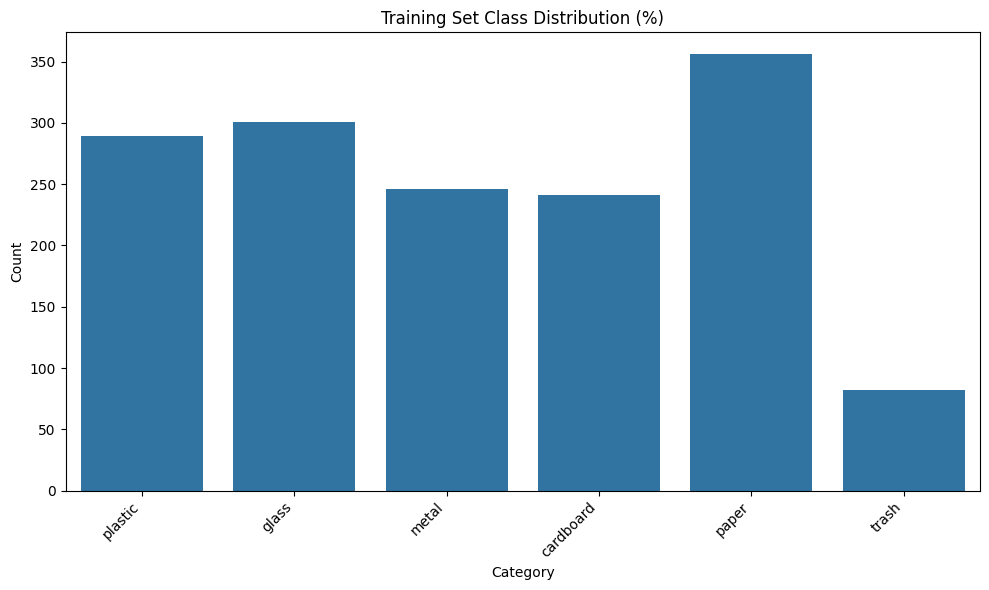

Validation Set Class Distribution (Counts): Counter({'paper': 119, 'glass': 100, 'plastic': 96, 'metal': 82, 'cardboard': 81, 'trash': 28})


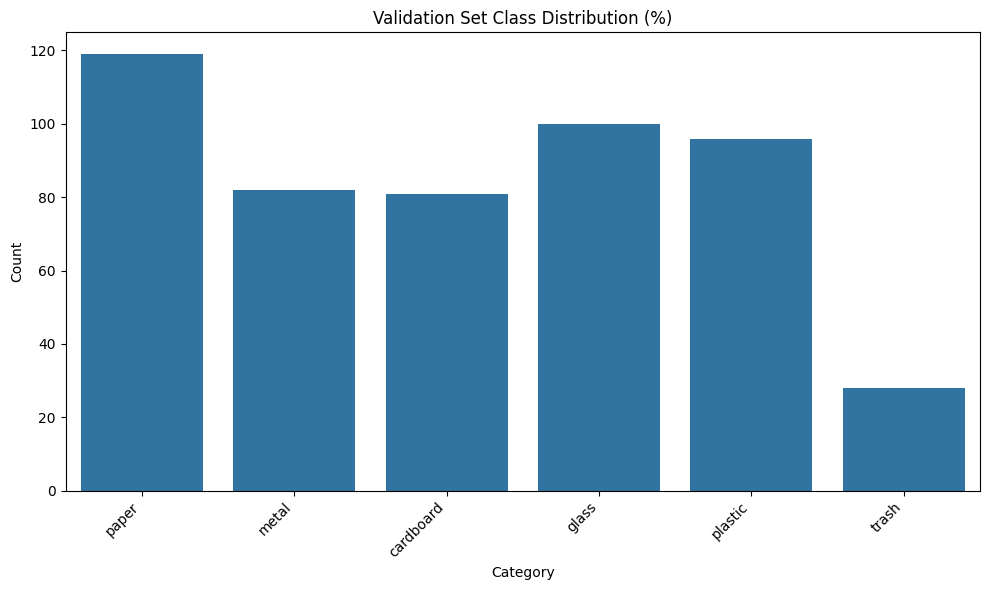

Test Set Class Distribution (Counts): Counter({'paper': 119, 'glass': 100, 'plastic': 97, 'metal': 82, 'cardboard': 81, 'trash': 27})


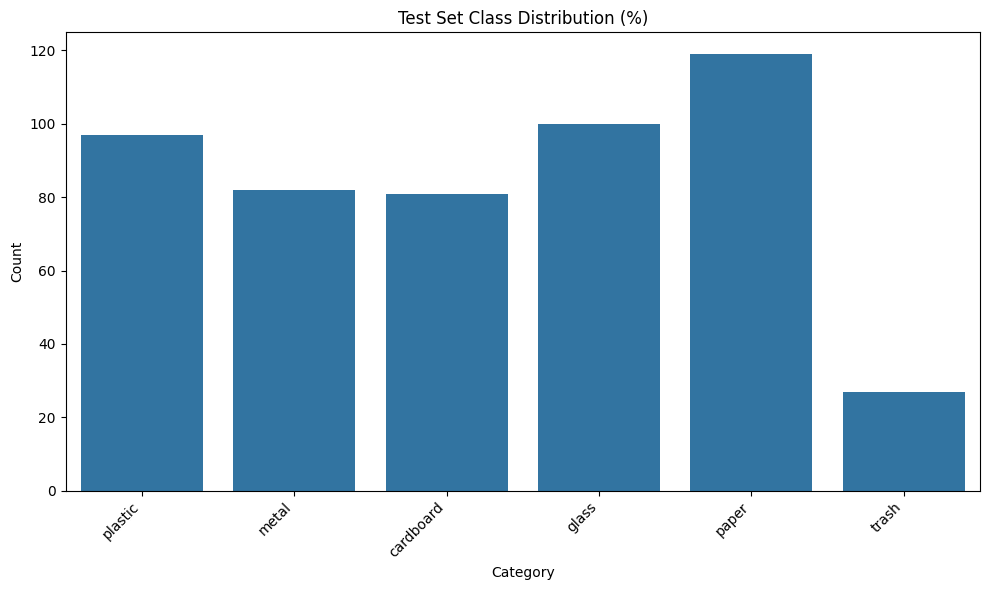


⚠️ Class imbalance detected! The ratio of max to min class count is 4.34.
This confirms the challenge stated in the project description.


In [51]:
# 1.4 Check the number of images per class and plot distributions
print("\n--- Checking Image Count and Distributions per Split ---")

# Overall distribution
overall_dist = Counter(df['label'])
print("Overall Class Distribution (Counts):", overall_dist)
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

# Training set distribution
train_dist = Counter(train_df['label'])
print("Training Set Class Distribution (Counts):", train_dist)
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")

# Validation set distribution
val_dist = Counter(val_df['label'])
print("Validation Set Class Distribution (Counts):", val_dist)
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")

# Test set distribution
test_dist = Counter(test_df['label'])
print("Test Set Class Distribution (Counts):", test_dist)
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")


# Detect and report imbalance based on overall distribution
min_count = min(overall_dist.values())
max_count = max(overall_dist.values())
if min_count > 0 and max_count / min_count > 1.5: # Threshold for considering imbalance
    print("\n⚠️ Class imbalance detected! The ratio of max to min class count is "
          f"{max_count / min_count:.2f}.")
    print("This confirms the challenge stated in the project description.")
else:
    print("\nClass distribution appears relatively balanced (or no images found).")


--- Visualizing Sample Images ---
Found 2527 validated image filenames belonging to 6 classes.


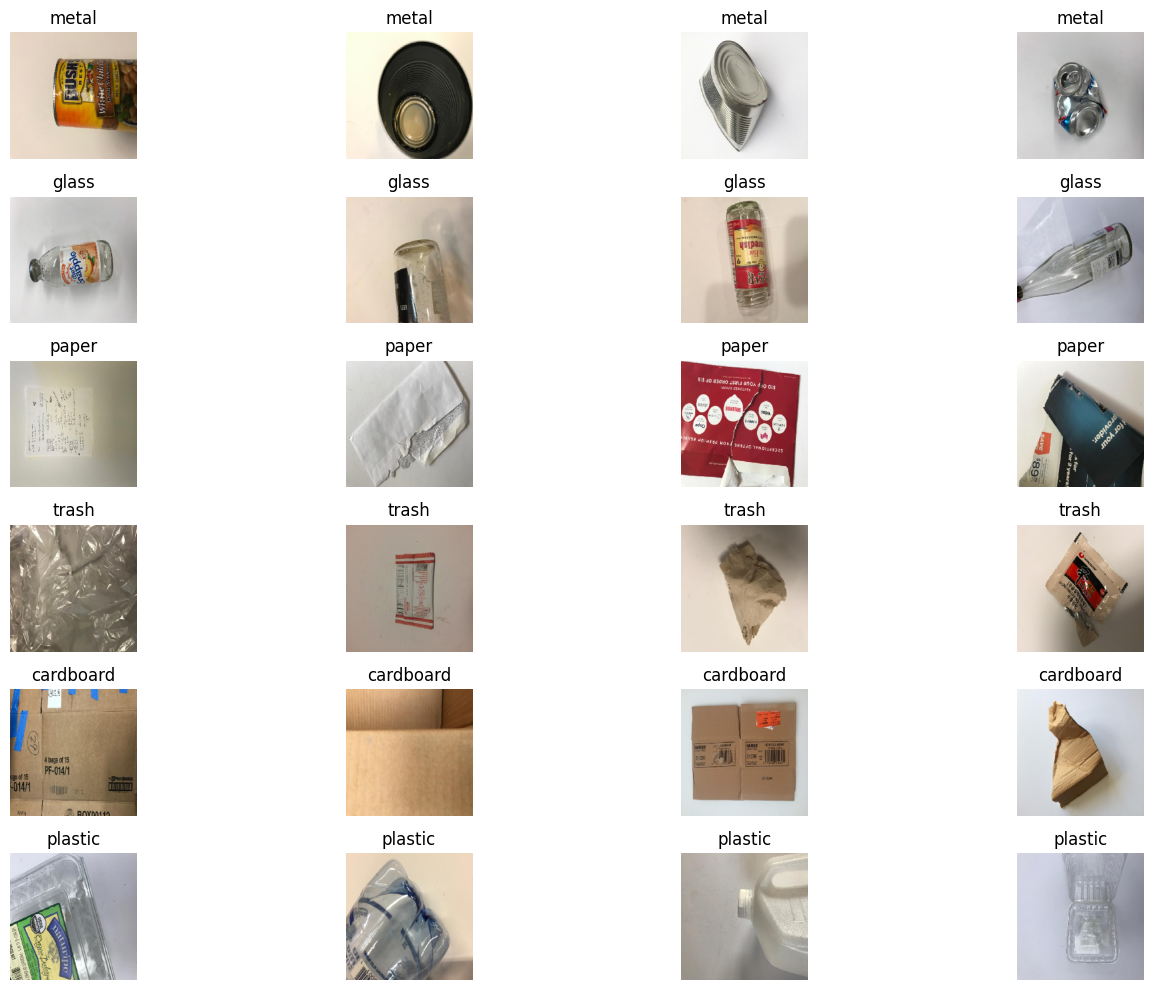

In [52]:
# 1.5 Visualize sample images from each class (same as before)
print("\n--- Visualizing Sample Images ---")
plt.figure(figsize=(15, 10))
num_samples_per_class = 4 # Number of samples to visualize per class

# Create a generator for visualization (just for this section)
# It's important to use a generator that doesn't shuffle for predictable sampling
vis_datagen = ImageDataGenerator(rescale=1./255)
vis_generator = vis_datagen.flow_from_dataframe(
    dataframe=df, # Use the full dataframe for visualization
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=1, # Get one image at a time
    class_mode='categorical',
    shuffle=False
)

samples_per_class_collected = {name: 0 for name in class_names}
displayed_images = 0

for i in range(len(vis_generator)): # Iterate through all images
    if displayed_images >= len(class_names) * num_samples_per_class:
        break # Stop if we have enough samples

    img_batch, label_batch = vis_generator[i]
    img = img_batch[0] # Get the single image from the batch
    label_idx = tf.argmax(label_batch[0]).numpy()
    class_name = class_names[label_idx]

    if samples_per_class_collected[class_name] < num_samples_per_class:
        ax = plt.subplot(len(class_names), num_samples_per_class, displayed_images + 1)
        # Convert to uint8 for imshow, assuming values are 0-1 from rescaling
        plt.imshow(img)
        plt.title(f"{class_name}")
        plt.axis("off")
        samples_per_class_collected[class_name] += 1
        displayed_images += 1

plt.tight_layout()
plt.show()


In [53]:
# 1.6 Understand image dimensions, color channels, and class labels.
print("\n--- Image and Label Characteristics ---")

# Get one batch from the training generator (or full dataframe generator) to inspect properties
# Use a generator that just rescales for accurate dimensions
temp_char_datagen = ImageDataGenerator(rescale=1./255)
temp_char_generator = temp_char_datagen.flow_from_dataframe(
    dataframe=df, # Use full dataset for this
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=1, # Get one image at a time
    class_mode='categorical',
    shuffle=False
)

# Iterate through the generator to get the first batch
for images, labels_one_hot in temp_char_generator:
    sample_image = images[0]
    sample_label_one_hot = labels_one_hot[0]

    print(f"Sample Image Dimensions: {sample_image.shape}") # (height, width, channels)
    print(f"Sample Image Data Type: {sample_image.dtype}") # Should be float32 due to rescaling

    # Color Channels
    if sample_image.shape[-1] == 3:
        print("Color Channels: 3 (RGB)")
    elif sample_image.shape[-1] == 1:
        print("Color Channels: 1 (Grayscale)")
    else:
        print(f"Color Channels: {sample_image.shape[-1]} (Unusual)")

    print(f"Number of Classes (from one-hot label length): {len(sample_label_one_hot)}")
    print(f"Example One-Hot Label: {sample_label_one_hot}") # Removed .numpy()
    print(f"Corresponding Class Name: {class_names[tf.argmax(sample_label_one_hot).numpy()]}")
    break # Only need one batch for this info


print("\nData exploration complete. The `train_df`, `val_df`, and `test_df` are now ready for model building.")

# --- IMPORTANT: Return these DataFrames for the next sections of your main script ---
# You would then pass train_df, val_df, test_df to the next parts of your code.
# For a script, you might want to wrap this section into a function that returns these DFs.
# For now, these DFs are globally available if you run this section first.
# These will be the train_df and test_df used by the feature extraction steps later.
# If you plan to use val_df for fine-tuning the base model or for validation of the overall pipeline, keep it.

# These are the dataframes that will be used by the subsequent sections (e.g., for feature extraction)
# (train_df, val_df, test_df are now defined globally by this section)


--- Image and Label Characteristics ---
Found 2527 validated image filenames belonging to 6 classes.
Sample Image Dimensions: (224, 224, 3)
Sample Image Data Type: float32
Color Channels: 3 (RGB)
Number of Classes (from one-hot label length): 6
Example One-Hot Label: [0. 0. 1. 0. 0. 0.]
Corresponding Class Name: metal

Data exploration complete. The `train_df`, `val_df`, and `test_df` are now ready for model building.


In [54]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 2. Handle Class Imbalance
print("\n--- Handling Class Imbalance ---")

# Calculate class counts from the training set
class_counts = train_df['label'].value_counts().sort_index()
print("Class Counts (Training Set):", class_counts)

# Calculate class weights
# This is useful for training models on imbalanced datasets
# The 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
classes = np.unique(train_df['label'])
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_df['label']
)

# Create a dictionary of class weights for use in model training
class_weights = dict(zip(classes, class_weights_array))

print("Calculated Class Weights:", class_weights)


--- Handling Class Imbalance ---
Class Counts (Training Set): label
cardboard    241
glass        301
metal        246
paper        356
plastic      289
trash         82
Name: count, dtype: int64
Calculated Class Weights: {'cardboard': np.float64(1.0477178423236515), 'glass': np.float64(0.8388704318936877), 'metal': np.float64(1.0264227642276422), 'paper': np.float64(0.7092696629213483), 'plastic': np.float64(0.8737024221453287), 'trash': np.float64(3.0792682926829267)}



## 2.  Data Preprocessing / Preparation
- Resize and rescale images.
- Apply data augmentation (e.g., `RandomFlip`, `RandomRotation`, `RandomZoom`) to improve generalization.
- Normalize images (using `preprocess_input` if using pre-trained models like EfficientNet).

In [55]:
#--- 2. Data Preprocessing / Preparation ---
print("\n--- 2. Data Preprocessing / Preparation ---")


--- 2. Data Preprocessing / Preparation ---


In [56]:
# 2.1 Resize and Rescale Images
print("2.1 Resizing and Rescaling Images:")
print(f"- All images will be resized to {IMG_SIZE[0]}x{IMG_SIZE[1]} pixels.")
print("- Pixel values will be rescaled from [0, 255] to [0.0, 1.0] by dividing by 255.")
print("  This is handled by `rescale=1./255` in `ImageDataGenerator`.")

2.1 Resizing and Rescaling Images:
- All images will be resized to 224x224 pixels.
- Pixel values will be rescaled from [0, 255] to [0.0, 1.0] by dividing by 255.
  This is handled by `rescale=1./255` in `ImageDataGenerator`.


In [57]:
# 2.2 Apply Data Augmentation
print("\n2.2 Applying Data Augmentation:")
print("- Data augmentation techniques are applied to the training set to prevent overfitting")
print("  and improve the model's ability to generalize to unseen images.")
print("  This also implicitly helps in mitigating class imbalance by creating variations of existing samples.")
print("  Techniques used via `ImageDataGenerator`:")
print("  - `rotation_range=20`: Random rotations up to 20 degrees.")
print("  - `width_shift_range=0.2`: Random horizontal shifts up to 20% of image width.")
print("  - `height_shift_range=0.2`: Random vertical shifts up to 20% of image height.")
print("  - `shear_range=0.2`: Shear transformations.")
print("  - `zoom_range=0.2`: Random zooms.")
print("  - `horizontal_flip=True`: Random horizontal flips.")
print("  - `fill_mode='nearest'`: Strategy for filling in new pixels created by transformations.")

# Define the ImageDataGenerator instances for each purpose
# Training Data Generator (with augmentation) - Primarily for visualization or if fine-tuning top layers
train_augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Feature Extraction Data Generators (NO augmentation, only initial rescale)
# These will be used to generate features for the SVM
feature_extraction_datagen = ImageDataGenerator(rescale=1./255)

# Setup the actual generators for feature extraction
train_features_generator = feature_extraction_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Crucial for matching features to labels
)

val_features_generator = feature_extraction_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_features_generator = feature_extraction_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\nTraining set images will be augmented: {train_augmented_datagen is not None}")
print(f"Feature extraction for SVM will use non-augmented images (only resized/rescaled): Yes")



2.2 Applying Data Augmentation:
- Data augmentation techniques are applied to the training set to prevent overfitting
  and improve the model's ability to generalize to unseen images.
  This also implicitly helps in mitigating class imbalance by creating variations of existing samples.
  Techniques used via `ImageDataGenerator`:
  - `rotation_range=20`: Random rotations up to 20 degrees.
  - `width_shift_range=0.2`: Random horizontal shifts up to 20% of image width.
  - `height_shift_range=0.2`: Random vertical shifts up to 20% of image height.
  - `shear_range=0.2`: Shear transformations.
  - `zoom_range=0.2`: Random zooms.
  - `horizontal_flip=True`: Random horizontal flips.
  - `fill_mode='nearest'`: Strategy for filling in new pixels created by transformations.
Found 1515 validated image filenames belonging to 6 classes.
Found 506 validated image filenames belonging to 6 classes.
Found 506 validated image filenames belonging to 6 classes.

Training set images will be augmented: Tr

In [58]:
# 2.3 Normalise Images using preprocess_input
print("\n2.3 Normalizing Images for Pre-trained ResNet50:")
print("- ResNet50, being a pre-trained model on ImageNet, expects specific pixel normalization.")
print("- After initial rescaling to [0.0, 1.0], images need further normalization (e.g., zero-centered, specific mean/std).")
print("- This is handled by `tf.keras.applications.resnet50.preprocess_input` function.")
print("- This function will be applied *after* images are loaded and rescaled by `ImageDataGenerator`")
print("  but *before* they are fed into the frozen ResNet50 base model for feature extraction.")
print("  This ensures input format compatibility with the pre-trained weights.")

print("\nData preprocessing setup complete. Generators are configured.")


2.3 Normalizing Images for Pre-trained ResNet50:
- ResNet50, being a pre-trained model on ImageNet, expects specific pixel normalization.
- After initial rescaling to [0.0, 1.0], images need further normalization (e.g., zero-centered, specific mean/std).
- This is handled by `tf.keras.applications.resnet50.preprocess_input` function.
- This function will be applied *after* images are loaded and rescaled by `ImageDataGenerator`
  but *before* they are fed into the frozen ResNet50 base model for feature extraction.
  This ensures input format compatibility with the pre-trained weights.

Data preprocessing setup complete. Generators are configured.


# **3. ResNet50 Feature Extraction**

In [59]:
# --- 3. ResNet50 Feature Extraction ---
print("\n--- 3. ResNet50 Feature Extraction ---")

# Load pre-trained ResNet50 model without the top (classification) layer
# Note: ResNet50 was originally trained on 224x224 images. While Keras allows
# different input_shapes, feature quality might be best at its native resolution.
# For 128x128, performance might be slightly impacted or require re-tuning.


--- 3. ResNet50 Feature Extraction ---


In [61]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create a model to extract features
feature_extractor = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))
feature_extractor.summary()

# Function to get features from a generator with preprocessing
def get_features(generator, feature_model):
    all_features = []
    all_labels = []
    num_samples = generator.samples
    generator.reset() # Ensure we start from the beginning for consistent feature extraction

    steps_per_epoch = int(np.ceil(num_samples / generator.batch_size))
    print(f"  Processing {num_samples} samples in {steps_per_epoch} steps...")

    for i in range(steps_per_epoch):
        images_batch, labels_batch_one_hot = next(generator)
        # Apply ResNet50's specific preprocessing here
        preprocessed_images_batch = preprocess_input(images_batch)
        features_batch = feature_model.predict(preprocessed_images_batch, verbose=0)
        all_features.append(features_batch)
        all_labels.append(tf.argmax(labels_batch_one_hot, axis=1).numpy())

    return np.vstack(all_features), np.concatenate(all_labels)


# Extract features from training set
print("Extracting features from training set...")
X_train_features, y_train_encoded = get_features(train_features_generator, feature_extractor)

# Extract features from validation set
print("Extracting features from validation set...")
X_val_features, y_val_encoded = get_features(val_features_generator, feature_extractor)

# Extract features from test set
print("Extracting features from test set...")
X_test_features, y_test_encoded = get_features(test_features_generator, feature_extractor)

print(f"Shape of extracted training features: {X_train_features.shape}")
print(f"Shape of extracted validation features: {X_val_features.shape}")
print(f"Shape of extracted test features: {X_test_features.shape}")

# --- 2.1 (Re-confirming) Handling Class Imbalance for SVM Training ---
print("\n--- Re-confirming Class Imbalance Handling (for SVM) ---")

unique_labels_for_weights = np.unique(y_train_encoded)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=unique_labels_for_weights,
    y=y_train_encoded
)
class_weights_dict = dict(zip(unique_labels_for_weights, class_weights))
print(f"Computed Class Weights (for SVM): {class_weights_dict}")
print(f"Class distribution in training data (counts): {Counter(y_train_encoded)}")
print(f"Class names (mapping to indices): {dict(zip(unique_labels_for_weights, [class_names[i] for i in unique_labels_for_weights]))}")


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

Extracting features from training set...
  Processing 1515 samples in 48 steps...
Extracting features from validation set...
  Processing 506 samples in 16 steps...
Extracting features from test set...
  Processing 506 samples in 16 steps...
Shape of extracted training features: (1515, 2048)
Shape of extracted validation features: (506, 2048)
Shape of extracted test features: (506, 2048)

--- Re-confirming Class Imbalance Handling (for SVM) ---
Computed Class Weights (for SVM): {np.int64(0): np.float64(1.0477178423236515), np.int64(1): np.float64(0.8388704318936877), np.int64(2): np.float64(1.0264227642276422), np.int64(3): np.float64(0.7092696629213483), np.int64(4): np.float64(0.8737024221453287), np.int64(5): np.float64(3.0792682926829267)}
Class distribution in training data (counts): Counter({np.int64(3): 356, np.int64(1): 301, np.int64(4): 289, np.int64(2): 246, np.int64(0): 241, np.int64(5): 82})
Class names (mapping to indices): {np.int64(0): 'cardboard', np.int64(1): 'glass', 

In [62]:
# --- 4. Train SVM Classifier ---
print("\n--- 4. Train SVM Classifier ---")

svm_classifier = SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced')

print("Training SVM classifier on extracted features...")
svm_classifier.fit(X_train_features, y_train_encoded)
print("SVM training complete.")



--- 4. Train SVM Classifier ---
Training SVM classifier on extracted features...
SVM training complete.



--- 5. Evaluate SVM Classifier ---
SVM Accuracy on Test Set: 0.2332

Classification Report (SVM):
              precision    recall  f1-score   support

   cardboard       0.18      0.96      0.30        81
       glass       0.12      0.01      0.02       100
       metal       0.60      0.18      0.28        82
       paper       0.65      0.20      0.31       119
     plastic       0.00      0.00      0.00        97
       trash       0.00      0.00      0.00        27

    accuracy                           0.23       506
   macro avg       0.26      0.23      0.15       506
weighted avg       0.30      0.23      0.17       506


Confusion Matrix (SVM):


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


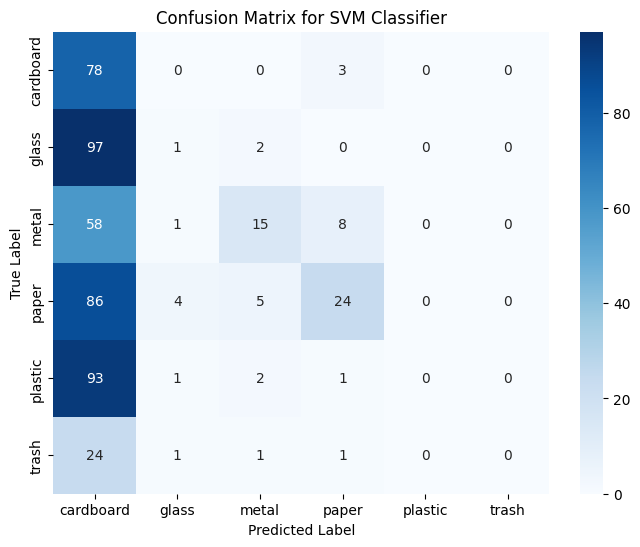

In [63]:
# --- 5. Evaluate SVM Classifier ---
print("\n--- 5. Evaluate SVM Classifier ---")

y_pred_svm = svm_classifier.predict(X_test_features)

accuracy_svm = accuracy_score(y_test_encoded, y_pred_svm)
print(f"SVM Accuracy on Test Set: {accuracy_svm:.4f}")

print("\nClassification Report (SVM):")
print(classification_report(y_test_encoded, y_pred_svm, target_names=class_names))

print("\nConfusion Matrix (SVM):")
cm_svm = confusion_matrix(y_test_encoded, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for SVM Classifier')
plt.show()


--- 6. Hyperparameter Tuning for SVM (GridSearchCV) ---
This step can be computationally intensive and may take a significant amount of time.
It uses GridSearchCV to find the best C and gamma parameters for the RBF kernel SVM.
Starting GridSearchCV for SVM hyperparameter tuning (this may take a while)...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Best parameters found: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best cross-validation score: 0.4884

Best SVM Accuracy on Test Set: 0.5079

Classification Report (Best SVM):
              precision    recall  f1-score   support

   cardboard       0.61      0.52      0.56        81
       glass       0.48      0.44      0.46       100
       metal       0.51      0.43      0.46        82
       paper       0.52      0.62      0.57       119
     plastic       0.50      0.57      0.53        97
       trash       0.28      0.26      0.27        27

    accuracy                           0.51       506
   macro avg       0.48  

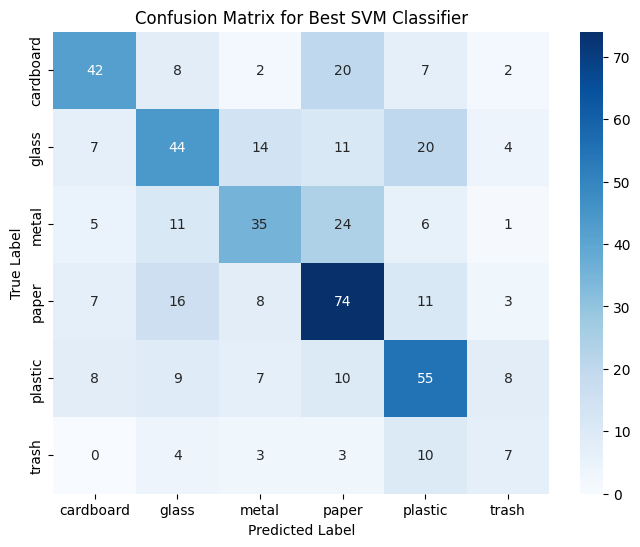

In [65]:
# --- 6. Hyperparameter Tuning for SVM (GridSearchCV) ---
print("\n--- 6. Hyperparameter Tuning for SVM (GridSearchCV) ---")
print("This step can be computationally intensive and may take a significant amount of time.")
print("It uses GridSearchCV to find the best C and gamma parameters for the RBF kernel SVM.")

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}

grid_search = GridSearchCV(SVC(probability=True, random_state=42, class_weight='balanced'),
                           param_grid, cv=3, verbose=2, n_jobs=-1)

print("Starting GridSearchCV for SVM hyperparameter tuning (this may take a while)...")
grid_search.fit(X_train_features, y_train_encoded)

print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

best_svm_classifier = grid_search.best_estimator_

y_pred_best_svm = best_svm_classifier.predict(X_test_features)

accuracy_best_svm = accuracy_score(y_test_encoded, y_pred_best_svm)
print(f"\nBest SVM Accuracy on Test Set: {accuracy_best_svm:.4f}")

print("\nClassification Report (Best SVM):")
print(classification_report(y_test_encoded, y_pred_best_svm, target_names=class_names))

print("\nConfusion Matrix (Best SVM):")
cm_best_svm = confusion_matrix(y_test_encoded, y_pred_best_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_svm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Best SVM Classifier')
plt.show()


In [66]:
# --- 7. Save the trained SVM model ---
print("\n--- 7. Saving the trained SVM model ---")

final_svm_model = best_svm_classifier if 'best_svm_classifier' in locals() else svm_classifier
model_save_path = 'resnet50_svm_garbage_classifier.joblib'
joblib.dump(final_svm_model, model_save_path)
print(f"SVM model saved to {model_save_path}")

feature_extractor_save_path = 'resnet50_feature_extractor.h5'
feature_extractor.save(feature_extractor_save_path)
print(f"ResNet50 feature extractor saved to {feature_extractor_save_path}")


--- 7. Saving the trained SVM model ---
SVM model saved to resnet50_svm_garbage_classifier.joblib
ResNet50 feature extractor saved to resnet50_feature_extractor.h5



--- 8. How to Load and Use for Prediction ---



Predicting for image: plastic_079.jpg
Predicted class: paper (Confidence: 43.14%)


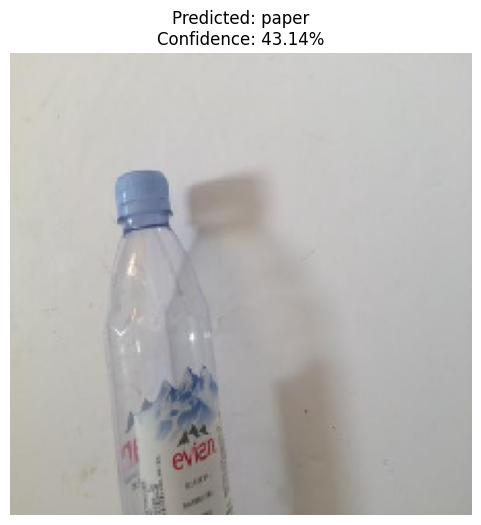


--- Testing with a few more random samples ---

Predicting for image: cardboard_040.jpg
Predicted class: paper (Confidence: 43.14%)


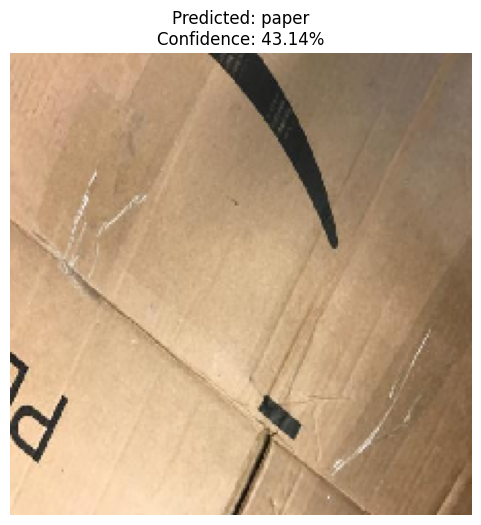


Predicting for image: glass_280.jpg
Predicted class: paper (Confidence: 43.14%)


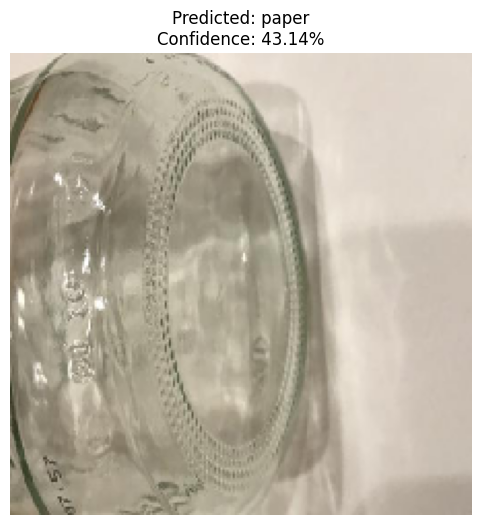


Predicting for image: glass_276.jpg
Predicted class: paper (Confidence: 43.14%)


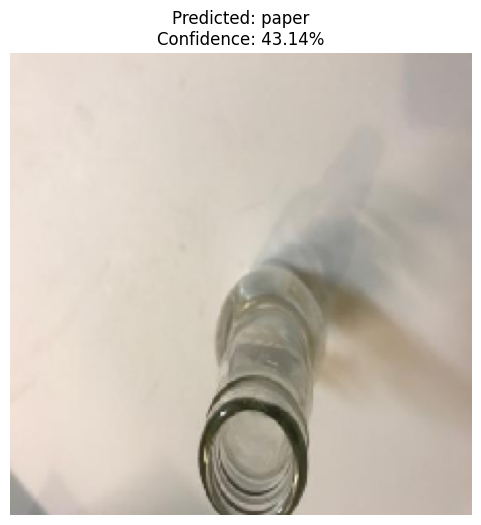


--- Script execution complete ---


In [67]:
# --- 8. How to load and use for prediction ---
print("\n--- 8. How to Load and Use for Prediction ---")

loaded_feature_extractor = tf.keras.models.load_model(feature_extractor_save_path)
loaded_svm_classifier = joblib.load(model_save_path)

def predict_garbage_image(image_path, feature_extractor_model, svm_model, class_names, img_size):
    """
    Loads an image, preprocesses it, extracts features, and makes a prediction.

    Args:
        image_path (str): Path to the input image file.
        feature_extractor_model (tf.keras.Model): The loaded ResNet50 feature extractor.
        svm_model (sklearn.svm.SVC): The loaded SVM classifier.
        class_names (list): List of class names in the correct order.
        img_size (tuple): Target size for the image (height, width).
    """
    print(f"\nPredicting for image: {os.path.basename(image_path)}")
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    preprocessed_img_array = preprocess_input(img_array)

    features = feature_extractor_model.predict(preprocessed_img_array, verbose=0)

    prediction_proba = svm_model.predict_proba(features)[0]
    predicted_class_idx = np.argmax(prediction_proba)
    predicted_class_name = class_names[predicted_class_idx]
    confidence = prediction_proba[predicted_class_idx] * 100

    print(f"Predicted class: {predicted_class_name} (Confidence: {confidence:.2f}%)")

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class_name}\nConfidence: {confidence:.2f}%")
    plt.axis('off')
    plt.show()
    return predicted_class_name, confidence

try:
    if not test_df.empty:
        sample_image_path = test_df['filepath'].iloc[0]
        predict_garbage_image(sample_image_path, loaded_feature_extractor, loaded_svm_classifier, class_names, IMG_SIZE)

        if len(test_df) > 5:
            print("\n--- Testing with a few more random samples ---")
            sample_indices = np.random.choice(len(test_df), 3, replace=False)
            for idx in sample_indices:
                sample_image_path = test_df['filepath'].iloc[idx]
                predict_garbage_image(sample_image_path, loaded_feature_extractor, loaded_svm_classifier, class_names, IMG_SIZE)
    else:
        print("\nTest DataFrame is empty, cannot run sample prediction.")
except Exception as e:
    print(f"\nCould not run sample prediction. Error: {e}")
    print("Please ensure the dataset was loaded correctly and test_df is populated.")

print("\n--- Script execution complete ---")






